
# <span style="color:rgb(106,127,16)">Overview of some tools</span>


<div style="text-align: right"><span style="color:rgb(106,127,16)">March 31, 2020 
    </span></div>
<br>


<br>



This lecture is an introductory overview to give you a sense of the broad utility of a few python tools you will encounter in later lectures. Each lecture or class activity is guided by a [Jupyter Notebook](https://jupyter.org/) (like this document), which combines executable code, mathematical formulae, and text notes.  This overview notebook also serves to  check and verify that you have a working installation of some of the python modules we will need to use later. We shall delve into basic programming using python (after this overview and a few further start-up notes) starting from a [later  lecture](04_Conversion_table.ipynb).


The ability to program, analyze and compute with data are life skills.  They are useful well beyond your mathematics curriculum. To illustrate this claim, let us begin by considering the most pressing current issue in our minds as we begin these lectures: the progression of COVID-19 disease worldwide. The skills you will learn in depth later can be applied to understand many types of  data, including the data on COVID-19  disease progression. In this overview,  we shall use a few python tools to quickly obtain and visualize data on COVID-19 disease worldwide. The live data on COVID-19 (which is changing in as yet unknown ways) will also be used in several later activities.

Specifically, this notebook contains all the code needed to perform these tasks:

- download today's data on COVID-19 from a cloud repository,
- make a data frame object out of the data,
- use a geospatial module to put the data on a world map, 
- download county maps from US Census Bureau, and 
- visualize the COVID-19 data restricted to Oregon.

The material here is intended just to give you an overview of the various tools we will learn in depth later. There is no expectation that you can immediately digest the code here. The goal of this overview is merely to whet your appetite and motivate you to allocate time to learn the materials yet to come.


## The modules you need


These are the  python modules we shall use below. 

- `matplotlib` (for various plotting & visualization tools in python)
- `descartes` (for specialized visualization of maps using matplotlib)
- `gitpython` (to work in python with Git repositories)
- `pandas` (to make data frame structures out of raw data)
- `geopandas` (for analysis of geospatial data)
- `urllib` (for fetching resources at an internet url)

Please install these modules if you do not have them already. (If you do not have these installed, attempting to run the next cell will give you an error.)

In [4]:
import pandas as pd
import os
from git import Repo
import matplotlib.pyplot as plt
import geopandas as gpd
import urllib
import shutil
%matplotlib inline

## Get the data 


The Johns Hopkins University Center for Systems Science and Engineering 
has curated data on COVID-19 from multiple sources and provided it online 
as a "git" repository in a cloud server at    https://github.com/CSSEGISandData/COVID-19. (We shall learn 
a bit more about git in a [later lecture](03_Working_with_git.ipynb).)
These days, as the disease progresses, new data is being pushed into this repository every day. 


Git repositories in the cloud server can be *cloned* to 
get an identical local copy on our computers.
Let us  begin by cloning a copy of the Johns Hopkins COVID-19 data repository into a location in your computer. Please specify this location in your computer in the variable called `covidfolder` below. Once you have cloned the repository, the next time you run the same line of code, it does not clone it again. Instead, it only pulls  updates from the cloud to sync your local copy with the remote original.

In [10]:
# your local folder into which you want to download the covid data

covidfolder = '/workspaces/mth271content/data/covid19'

Remember this location where you have stored the COVID-19 data. You will need to return to it when you use the data during activities in later  days, including assignment projects.

In [11]:
if os.path.isdir(covidfolder):   # if repo exists, pull newest data 
    repo = Repo(covidfolder)
    repo.remotes.origin.pull()
else:                            # otherwise, clone from remote
    repo = Repo.clone_from('https://github.com/CSSEGISandData/COVID-19.git',
                           covidfolder)   
datadir = repo.working_dir + '/csse_covid_19_data/csse_covid_19_daily_reports'

The folder `datadir` contains many files (all of which can be listed here using the command `os.listdir(datadir)` if needed). The filenames begin with a date like `03-27-2020` and ends in `.csv`. The ending suffix `csv` stands for "comma separated values", a common simple format for storing uncompressed data.

## Examine the data for a specific date


The python module `pandas`, the workhorse for all data science tasks in python,  can make a `DataFrame` object out of each such `.csv` files. You will learn more about pandas later in the course.
For now, let us pick a recent date, say March 27, 2020,  and examine the COVID-19 data for that date.

In [13]:
c = pd.read_csv(datadir+'/03-27-2020.csv')

The `DataFrame` object `c` has over 3000 rows. An examination of the first five rows already tells us a lot about the data layout:

In [14]:
c.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-03-27 22:14:55,34.223334,-82.461707,4,0,0,4,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-03-27 22:14:55,30.295065,-92.414197,8,1,0,7,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-03-27 22:14:55,37.767072,-75.632346,2,0,0,2,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-03-27 22:14:55,43.452658,-116.241552,54,0,0,54,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-03-27 22:14:55,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"


Note that depending on how the output is rendered where you are reading this, the later columns may be line-wrapped or may be visible only after scrolling to the edges.  This object `c`, whose `head`  part is printed above, looks like a structured array. There are features corresponding to locations, as specified in latitude `Lat` and longitude `Long_`. The columns  `Confirmed`, `Deaths`, and `Recovered` represents the number of confirmed cases, deaths, and recovered cases  due to COVID-19 at a corresponding location.

## Put the data on a map

Data like that in `c` contains geospatial information. One way to visualize geospatial data is to  indicate the quantity of interest on a map. We shall visualize the data in the `Confirmed` column by positioning a marker at its geographical location and make the marker size correspond to  the number of confirmed cases at that position. The module `geopandas` (`gpd`) is well-suited for visualizing geospatial data. It is built on top of the `pandas` library. So it is easy to convert our `pandas` object `c` to a `geopandas` object.

In [16]:
# make a geometry object from Lat, Long
geo = gpd.points_from_xy(c['Long_'], c['Lat']) 
# give the geometry to geopandas together with c
gc = gpd.GeoDataFrame(c, geometry=geo)         
gc.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,geometry
0,45001.0,Abbeville,South Carolina,US,2020-03-27 22:14:55,34.223334,-82.461707,4,0,0,4,"Abbeville, South Carolina, US",POINT (-82.46171 34.22333)
1,22001.0,Acadia,Louisiana,US,2020-03-27 22:14:55,30.295065,-92.414197,8,1,0,7,"Acadia, Louisiana, US",POINT (-92.4142 30.29506)
2,51001.0,Accomack,Virginia,US,2020-03-27 22:14:55,37.767072,-75.632346,2,0,0,2,"Accomack, Virginia, US",POINT (-75.63235 37.76707)
3,16001.0,Ada,Idaho,US,2020-03-27 22:14:55,43.452658,-116.241552,54,0,0,54,"Ada, Idaho, US",POINT (-116.24155 43.45266)
4,19001.0,Adair,Iowa,US,2020-03-27 22:14:55,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US",POINT (-94.47106 41.33076)


The only difference between `gc` and `c` is the last column, which contains the new geometry objects representing points on the globe. Next, in order to  place markers at these points on a map of the world, we need to get a simple *low resolution* world map:  

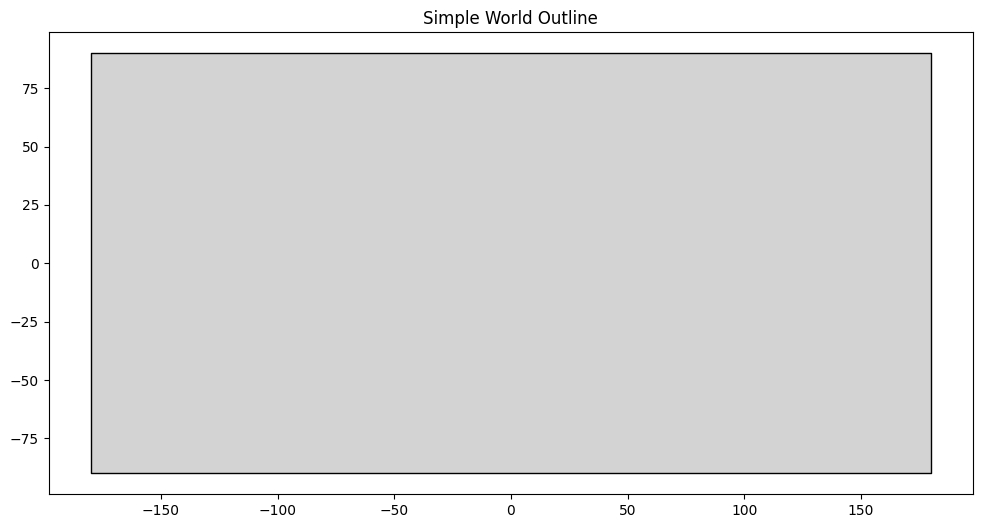

In [41]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot();

# Create a simple world outline from scratch
import numpy as np
from shapely.geometry import Polygon

# Create a simple rectangular world boundary
world_boundary = Polygon([(-180, -90), (180, -90), (180, 90), (-180, 90)])
world = gpd.GeoDataFrame([1], geometry=[world_boundary], crs="EPSG:4326")

world.plot(edgecolor="black", facecolor="lightgray", figsize=(12, 6))
plt.title("Simple World Outline")
plt.show()

You can download and use maps with better resolution from [Natural Earth](http://www.naturalearthdata.com/), but that will be too far of a digression for this overview.  On top of the above low resolution  map, we can now put the markers whose sizes are proportional to the number of confirmed cases. 

In [29]:
base = world.plot(alpha=0.3)
msz = 500 * gc['Confirmed'] / gc['Confirmed'].max()
gc.plot(ax=base, column='Confirmed', markersize=msz, alpha=0.7); 

NameError: name 'world' is not defined

These python tools have made it incredibly easy for us to immediately  identify the COVID-19 trouble spots in the world. Moreover, these visualizations can be updated easily by re-running this code as data becomes available for other days.

## Restricting to Oregon

Focusing on our part of the world, let us see how to restrict the COVID-19 data in the data frame `c` to Oregon. 

In [ ]:
co = c[c['Province_State']=='Oregon']

The variable `co` now contains the data restricted to Oregon. However, we are now presented with a problem. To visualize the restricted data, we need a map of Oregon.  The module `geopandas` does not carry  any 
information about Oregon and its counties.
However this information is available from the [United States Census Bureau](https://www.census.gov/).  (By the way, the 2020 census is happening now! Do not forget to respond to their survey. They are one of our authoritative sources of quality data.) 

To visualize the COVID-19 information on a map of Oregon, we need to get the county boundary information from the census bureau.  This illustrates a common situation that arises when trying to analyze data: it is often necessary to procure and merge data from  multiple sources in order to  understand a real-world phenomena. 
 
A quick internet search reveals the census page with county information. The information is available in an  online file `cb_2018_us_county_500k.zip` at the URL below. Python allows you to  download this file using its `urllib` module without even needing to leave this notebook.

In [21]:
# url of the data
census_url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip'

# location of your download
your_download_folder = '../../data_external'
if not os.path.isdir(your_download_folder):
    os.mkdir(your_download_folder)
us_county_file = your_download_folder + '/cb_2018_us_county_500k.zip'

# download if the file doesn't already exist 
if not os.path.isfile(us_county_file):
    with urllib.request.urlopen(census_url) as response, open(us_county_file, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)

Now, your local computer has a zip file,  which has among its contents, files with geometry information on the county boundaries, which can be read by `geopandas`. We let `geopandas` directly read in the zip file:  it knows which information to extract from the zip archive to make a data frame with geometry. 

In [ ]:
us_counties = gpd.read_file(f"zip://{us_county_file}")
us_counties.head()

The object `us_counties`  has information about all the counties. Now, we need to restrict this data to just that of Oregon.  Looking at the columns, we find something called STATEFP.  Searching through the [government pages](https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/nlt-record-layouts.html), we find that  STATEFP refers to a 2-character state FIPS code. 
The FIPS code refers to [Federal Information Processing Standard](https://en.wikipedia.org/wiki/FIPS_county_code)
which was a "standard" at one time, then deemed obsolete, but still continues to be used today. All that aside, it suffices to note that Oregon's FIPS code is 41. Once we know this, python makes it is easy to restrict the data to Oregon: 

In [ ]:
ore = us_counties[us_counties['STATEFP']=='41']
ore.plot();

Now we have the Oregon  data in two data frames, `ore` and `co`. We must combine the two data frames. This is again a situation so often encountered when dealing with real data that there is a facility for it in `pandas` called `merge`. Both data has FIPS codes: in `ore` you find it under column GEOID, and in `co` you find it called `FIPS`. The merged data frame is represented by the variable `orco` below:

In [ ]:
ore = ore.astype({'GEOID': 'int64'}).rename(columns={'GEOID' : 'FIPS'})
co = co.astype({'FIPS': 'int64'})
orco = pd.merge(ore, co.iloc[:,:-1], on='FIPS')

The `orco` object now has both the geometry information as well as the COVID-19 information, making it extremely easy to visualize.

In [ ]:
# plot coloring counties by number of confirmed cases

fig, ax = plt.subplots(figsize=(12, 8))
orco.plot(ax=ax, column='Confirmed', legend=True, 
          legend_kwds={'label': '# confimed cases', 
                       'orientation':'horizontal'})

# label the counties 

for x, y, county in zip(orco['Long_'], orco['Lat'], orco['NAME']):
    ax.text(x, y, county, color='grey')
    
ax.set_title('Confirmed COVID-19 cases in Oregon as of March 27 2020')
ax.set_xlabel('Latitude'); ax.set_ylabel('Longitude');

This is an example of a [chloropleth map](https://en.wikipedia.org/wiki/Choropleth_map),   a map where regions are colored or shaded in proportion to some data variable. It is an often-used data visualization tool. 

## Ask the data

Different ways of displaying data often give different insights. There are many visualization tools in the python ecosystem and you will become more acquainted with these as we proceed.  

Meanwhile, you might have many questions whose answers already lie in the data we have downloaded.  For example, you may wonder how  Oregon is doing in terms of COVID-19 outbreak  compared to the  other two west coast states. Here is the answer extracted from the same data:

![COVID-19 progression in the west coast](../figs/westcoast-2020-03-30.png)

How does the progression of infections in New York compare with Hubei where the disease started? Again the answer based on the data we have up to today is  easy to extract, and is displayed next.

![COVID-19 comparison: New York vs. Hubei](../figs/newyork-hubei-2020-03-30.png)

Of course, the COVID-19 situation is evolving, so these figures are immediately outdated after today's class. This situation is evolving in as yet unknown ways.  I am sure that  you, like me,  want to know more about how these plots will change in the next few months. You will be able to generate plots like this and learn many more data analysis skills from these lectures.  As you amass more technical skills, let me encourage you to answer your own questions on COVID-19 by returning to this overview, pulling the most recent data, and modifying the code here to your needs. In fact, some later assignments will require you to work further with this Johns Hopkins COVID-19 worldwide dataset. Visualizing the COVID-19 data for any other state, or indeed, any other region in the world, is easily accomplished by some small modifications to the code of this lecture.

 


<hr>

<span style="color:rgb(106,127,16); font-size:8pt">Author:</span> [<span style="color:rgb(106,127,16); font-size:8pt">Jay Gopalakrishnan</span>](http://web.pdx.edu/~gjay/) 
<br><span style="color:rgb(106,127,16); font-size:8pt">License:</span> [<span style="color:rgb(106,127,16) ; font-size:8pt">&copy;2020. CC-BY-SA</span>](https://creativecommons.org/licenses/by-sa/4.0/legalcode)
<br><span style="color:rgb(106,127,16) ; font-size:8pt">$\ll$</span>[<span style="color:rgb(106,127,16) ; font-size:8pt">Table of Contents</span>](./TOC.ipynb)



 
 



